# T000 · Target-conditioned de-novo drug design


**Note**: This talktorial is a part of TeachOpenCADD, a platform that aims to teach domain-specific skills and to provide pipeline templates as starting points for research projects.


Authors:
- Loulwah Arnaout, CADD Seminar, 2024, Saarland University
- Mohamed Moustafa Mohamadein Moustafa Salah, CADD Seminar, 2024, Saarland University

## Aim of this talktorial
In this tutorial we will learn:
1. **The fundamentals of de-novo drug design** using advanced computational tools to automate the generation of novel drug candidates for a specifc target.
2. **How to leverage [ACEGEN](https://github.com/Acellera/acegen-open)** which is a reinforcement learning based framework to generate molecules according to specifc target and constraints.
3. **using [MolScore](https://github.com/MorganCThomas/MolScore)** for evaluating the molecular attributes such as docking score, drug likness, and activity, and how to use these evaluations to guide the reinforcement learning process.
4. how to implement custome scoring functions, including:
   1. Docking score based on SMINA, for the generated molecule with our specific GPCR target.
   2. Classification model trained on data for our specific GPCR target.


### Contents in *Theory*
- [De-novo drug design](#De-novo-drug-design)
  - [Ligand-based vs structure-based methods](#Ligand-based-vs-structure-based-methods)
  - [Conditioning generation to a target](#Conditioning-generation-to-target)
- [ACEGEN workflow](#ACEGEN-workflow)
- [Biological background](#Biological-background)
  - DRD2 structure
  - Risperidone as reference ligand

### Contents in *Practical*
- [Environment setup](#Environment-setup)
- Config files preparation
- Scoring functions setup & Running ACEGEN
  - Docking-based generation
  - Model-based generation](#model-based-generation
- Analyzing results

### References

* Theoretical background:

    - Sheng Wang et al., "Structure of the D2 dopamine receptor bound to the atypical antipsychotic drug risperidone" [Nature, 2018](https://doi.org/10.1038/nature25758).
    - Morgan Thomas et al., "Integrating structure-based approaches in generative molecular design" [Current Opinion in Structural Biology, 2023](https://doi.org/10.1016/j.sbi.2023.102559).
    - Tiago Sousa et al., "Generative Deep Learning for Targeted Compound Design" Journal of Chemical [Information and Modeling, 2021](https://doi.org/10.1021/acs.jcim.0c01496).

* Packages:
    * ACEGEN
        - GitHub: [acegen-open](https://github.com/Acellera/acegen-open)
        - Paper: Albert Bou et al., "ACEGEN: Reinforcement Learning of Generative Chemical Agents for Drug Discovery" [Journal of Chemical Information and Modeling, 2024](https://doi.org/10.1021/acs.jcim.4c00895).
    * MolScore
        - GitHub: [MolScore](https://github.com/MorganCThomas/MolScore)
        - Paper: Morgan Thomas et al., "MolScore: a scoring, evaluation and benchmarking framework for generative models in de novo drug design" [Journal of Cheminformatics, 2024](https://doi.org/10.1186/s13321-024-00861-w).
    * PDBFixer: Peter Eastman, PDBFixer manual HTML
    * ProDy:
        - Website: [ProDy](http://www.bahargroup.org/prody/)
        - Paper: Ahmet Bakan et al., "ProDy: Protein Dynamics Inferred from Theory and Experiments" [Bioinformatics, 2011](https://doi.org/10.1093/bioinformatics/btr168).
* SwissDrugDesign Collection:
    - [SwissADME](http://www.swissadme.ch/)
    - [SwissTargetPrediction](http://www.swisstargetprediction.ch/)
    - [SwissDock](http://www.swissdock.ch/)

* Dataset:
    - D2 Receptor Binding Affinity: This dataset contains information on the binding affinity (pCHEMBL values) of various chemical compounds against the D2 dopamine receptor.

## Theory

### De-novo drug design

De-novo drug design is the generation of novel molecules from scratch using computational methods.

#### Ligand-based vs structure-based methods
Among the computational methods used in de-novo drug design are generative models, which train known architectures such as Recurrent Neural Networks (RNNs) or Autoencoders on existing data to guide the generation towards a target of choice.

For more details about Neural Networks and how they function, please refer to [Talktorial T022](https://projects.volkamerlab.org/teachopencadd/talktorials/T022_ligand_based_screening_neural_network.html).

The type of data used to train these models can be:

- **Ligand-based**: learning from known ligands of the target the properties of a potential drug.
- **Structure-based**: learning from the structure of the target itself the properties of a potential drug.


As opposed to ligand-based techniques that require a data-rich target, and are likely to produce drugs that resemble already known ligands, structure-based techniques focus on generating molecules that satisfy specific interactions with residues in the binding pocket, while also exploring novel chemical space.

#### Conditioning generation to target
To incorporate this structural information into the generation process, we can do so:

* **Explicitly** through Distribution Learning, by learning from the structure of the protein/ligand complex, the conditional distribution of small molecules.
* **Implicitly** by incorporating scores that provide information related to the target and its structure, such as docking scores or predicted binding affinities, but not the structure itself.

In this talktorial, we will be focusing on the latter and using model-based and docking-based custome scoring functions to guide the generation.

### ACEGEN workflow

**[ACEGEN](https://github.com/Acellera/acegen-open)** is a **[TorchRL](https://pytorch.org/rl/stable/index.html)**-based toolkit that can execute this task seamlessly. Among its many functionalities, it allows us to use the structure-implicit scores as reward values for Reinforcement Learning (RL), to update the model's parameters and optimize the scores of future proposed molecules.

The molecules can be scored easily using Molscore, a scoring function suite already incorporated into ACEGEN to evaluate the generated molecules by various measures, such as docking scores, predicted activity, synthesizability, and diversity. The scores can then be used along with one of the RL algorithms provided in ACEGEN, such as Reinvent, Augmented Hill-Climb (AHC), or Advantage Actor-Critic (A2C), to bias the generation process to desired properties.

<img alt="ACEGEN workflow" src="./images/ACEGEN_workflow.png" width="600" height="550"/>

*Figure 1:* 
General overview of any of the ACEGEN implementations. Different ACEGEN implementations vary in the algorithm used, and allow to customize the generative models and the scoring functions.
Figure and description taken from: [Journal of Chemical Information and Modeling, 2024](https://doi.org/10.1021/acs.jcim.4c00895).

#### Biological background

<h4 id="dopamine-receptor">Dopamine Receptor D2</h4>
In this talktorial, we will be generating molecules specific to the Dopamine Receptor D2, a target for antipsychotic drugs as well as Parkinson's disease drugs.

As its name suggests, this receptor binds the neurotransmitter Dopamine, which is involved in processes such as control of coordinated movement, metabolism and hormonal secretion.

#### Risperidone
The PDB entry used also includes the compound Risperidone in complex with our target. Risperidone is a widely prescribed antipsychotic drug. We will be using it as a pointer to the binding pocket to which we would like the generated molecules to be specific.

## Practical

The parctical part of this talkturial, covers the setting up of both the conda environment, and scoring functions, including a classification model based on the classification model and SMINA-based docking.

You will learn how to prepare the configuration files, and use ACEGEN and MolScore for molecule generation, evaluating these molecules to guide the reinforcement learning process.

This is followed by result analysis of the obtained molecules using SwissDrugDesign collection such as SwissADME, SwissTargetPrediction and SwissDock.

### Environment setup

In [ ]:
%%bash
conda env create -f environment.yaml
conda activate acegen

Follow these steps to set up the required environment for this talkturial:
1. **Install Conda**: make sure that you have conda installed on your system, if not please visit [Miniconda](https://docs.anaconda.com/miniconda/install/) and follow the installation instructions based on your system.
2. **Create the Environment**: Run the following command in your terminal:
   ```bash
   conda env create -f environment.yaml
   ```
3. **Activate the Environment**: Once created, activate the environment:
    ```bash
    conda activate acegen
    ```
4. **Install ACEGEN**: make sure that you have GIT installed on your system, then run the following command in your terminal:
    ```bash
    pip install git+https://github.com/Acellera/acegen-open.git
    ```

In [2]:
from pathlib import Path
import math
from pickle import dump

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix
from prody import fetchPDB, parsePDB, writePDB
from pdbfixer import PDBFixer
from openmm.app import PDBFile
from rdkit import Chem
from rdkit.Chem import Descriptors, Draw, PandasTools, rdFingerprintGenerator, DataStructs
from molscore.scoring_functions.sklearn_model import SKLearnClassifier

In [3]:
HERE = Path(_dh[-1])
DATA = HERE / "data"
CONFIGS = HERE / "configs"
SCRIPTS = HERE / "scripts"

### Scoring functions setup & Running ACEGEN 

#### Docking-based generation

In docking-based generation, we want to guide the model towards generating molecules with improved docking score to our target. To do so, we make use of Molscore, a scoring framework that allows the utlization of Smina for docking (please refer to Talktorial T015 to learn more about molecular docking). For each molecule generated, multiple docking poses are tested and the best one is kept along with its score. This score is then used as a reward value for reinforcement learning.


**Preparing protein and ligand files**

First, we need to prepare the input data necessary for this technique, and consisting of the structure of the target protein and a chosen reference ligand. This is done with the help of ProDy, a Python package that can be used to parse and manipulate PDB files.

The structure of the protein will be used for docking, and that of the ligand in its 3D-bioactive conformation will allow us to determine the coordinates of the binding pocket into which we will dock the generated molecules later on.

In [4]:
# retrieve structure of the protein/ligand complex from the PDB
pdb_id = "6cm4"
pdb_file = fetchPDB(pdb_id, folder=str(DATA))

# parse PDB structure to be able to manipulate its contents
structure = parsePDB(pdb_file)

# select protein and save in a separate file
protein = structure.select("protein")
writePDB(str(DATA / "protein.pdb"), protein)

# select ligand and save in a separate file
ligand_resname = "8NU"
ligand = structure.select(f"resname {ligand_resname}")
writePDB(str(DATA / "ligand.pdb"), ligand)

@> Connecting wwPDB FTP server RCSB PDB (USA).
@> Downloading PDB files via FTP failed, trying HTTP.
@> 6cm4 downloaded (data/6cm4.pdb.gz)
@> PDB download via HTTP completed (1 downloaded, 0 failed).
@> 3236 atoms and 1 coordinate set(s) were parsed in 0.03s.


'/home/ms/Current/cadd-seminar/Final/Topic4b_Acegen/data/ligand.pdb'

To prepare the protein structure for docking, we use PDBFixer to find and add to it missing atoms and residues.

In [5]:
# read structure file
fixer = PDBFixer(filename=str(DATA/"protein.pdb"))

# add missing information
fixer.findMissingResidues()
fixer.findMissingAtoms()
fixer.addMissingAtoms()
fixer.addMissingHydrogens()

# write prepared structure to a new pdb file
PDBFile.writeFile(fixer.topology, fixer.positions, open(DATA/'prepared_protein.pdb', 'w'))

In [6]:
!python {SCRIPTS/"reinvent.py"} --config-path {CONFIGS} --config-name SMINA_config_denovo.yaml

/home/ms/miniconda3/envs/acegen/lib/python3.10/site-packages/prolif/datafiles.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename
1 molecule converted
[2025-01-09 15:15:22,695][smina][DEBUG] - Written 1_0-0   | 0/1 [00:00<?, ?it/s]
[2025-01-09 15:15:22,695][smina][DEBUG] - Written 1_0-1
[2025-01-09 15:15:22,696][smina][DEBUG] - Written 1_0-2
[2025-01-09 15:15:22,696][smina][DEBUG] - Written 1_0-3
[2025-01-09 15:15:22,696][smina][DEBUG] - Written 1_0-4
[2025-01-09 15:15:22,697][smina][DEBUG] - Written 1_0-5
[2025-01-09 15:15:22,697][smina][DEBUG] - Smina called
[2025-01-09 15:15:52,010][smina][DEBUG] - Smina finished
[2025-01-09 15:15:52,011][smina][DEBUG] - Docking score for 1_0-0: -7.7
[2025-01-09 15:15:52,011][smina][DEBUG] - Found better 1_0-1: -9.1
[2025-01-09 15:15:52,012][smina][DEBUG] - Best scores: {'1_0': -9.1}
[2025-01-09 15:15:52,012][smina][DEBUG] - Returni

#### Model-based generation
In the model-based generation we want to guide the reinforcement learning model towards the generation of active molecules targeting our D2 Dopamine Receptor (D2R), using a dataset of compounds with known D2R binding affinities (pchembl_value_Mean).

We will start by building a random forest classification model (RFC) using Scikit-learn, using ECFP4 fingerprints of the molecules as features to classify them as either active or inactive according to a predefined threshold of their (pchembl_value_Mean).

This classification model will guide the generation process.

In [11]:
# First, we need to define a function to generate molecular fingerprints.
generator = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=1024)
def get_fingerprint(smiles):
    """
    Generates an ECFP4 fingerprint for a given molecule SMILES string.

    Parameters
    ----------
    smiles : str
        A SMILES string representing the molecule.

    Returns
    -------
    binary_array: np.ndarray or None
        A NumPy array representing the ECFP4 fingerprint with a size of 1024 if the 
        molecule is valid and the fingerprint could be generated. Returns None if the 
        provided SMILES string cannot be converted into a valid RDKit molecule.

    """
    molecule = Chem.MolFromSmiles(smiles)
    if molecule:
        fingerprint = generator.GetFingerprint(molecule)
        binary_array = np.zeros((1024,), dtype=int)
        DataStructs.ConvertToNumpyArray(fingerprint, binary_array)
        return binary_array
    else:
        return None

# Next, we'll prepare the data and label active/inactive molecules.
data = pd.read_csv(DATA/"D2_receptor_P14416WT_Papyrus_High.csv")
activity_threshold = 7
data['activity'] = data['pchembl_value_Mean'].apply(lambda x: 1 if x >= activity_threshold else 0)

# Now, we'll generate the ECFP4 feature vectors for our molecules.
fingerprints = pd.DataFrame({smile: get_fingerprint(smile) for smile in data["SMILES"]}).T.reset_index().drop("index", axis=1)
df = pd.concat([data, fingerprints], axis=1)

# Let's take a look at the processed dataframe.
df.head()

,Activity_ID,SMILES,target_id,pchembl_value_Mean,activity,0,1,2,3,4,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,AADCDMQTJNYOSS_on_P14416_WT,CCc1cc(Cl)c(OC)c(C(=O)NCC2CCCN2CC)c1O,P14416_WT,9.863333,1,0,0,0,0,1,...,0,0,0,0,0,1,0,1,0,0
1,AADWBQLQKGQDIM_on_P14416_WT,O=C(CCCN1CCC(c2cc3ccc2CCc2ccc(cc2)CC3)CC1)c1cc...,P14416_WT,7.645000,1,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,0
2,AAELEHAFAYIZRH_on_P14416_WT,O=C(NC1CCC(CCN2CCN(c3nsc4ccccc34)CC2)CC1)c1ccco1,P14416_WT,8.370000,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,AAIDTVFHOXBFSJ_on_P14416_WT,CC(C)CN1CCOC2c3cc4c(cc3CCC21)CCO4,P14416_WT,5.300000,0,0,1,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,AAONJNLMLWRZJE_on_P14416_WT,Cc1ccc2c(-c3nnc(SCCCN4CC5CC5(c5ccc(Cl)cc5)C4)n...,P14416_WT,6.400000,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [12]:
# For model training, we need to split the data appropriately.
X = df.drop(['Activity_ID', 'SMILES', 'target_id', 'pchembl_value_Mean', 'activity'], axis=1)
y = df['activity']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Using the best parameters found earlier, let's train our classification model.
model = RandomForestClassifier(
    random_state=42,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=300
)
model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=2, n_estimators=300, random_state=42)

In [14]:
# We want to evaluate the performance of our trained model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
# print the f1 score

Accuracy: 0.8623188405797102
Precision: 0.8647887323943662
Confusion Matrix:
 [[526  48]
 [ 85 307]]


In [15]:
# Finally, we'll save our trained model for future use with ACEGEN and MolScore.
with open(DATA/"model.pkl", 'wb') as file:
    dump(model, file)

In [16]:
# Now that we have our classification model, we can use it to guide molecule generation.

# grap the reinvent script from the installtion folder (site-packages - minicodna3/*)
!python {SCRIPTS/"reinvent.py"} --config-path {CONFIGS} --config-name RFC_config_denovo.yaml

/home/ms/miniconda3/envs/acegen/lib/python3.10/site-packages/prolif/datafiles.py:3: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import resource_filename
10111it [00:59, 170.84it/s]                                                     


In [24]:
# We'll now extract the molecules predicted to be active from our generated set.
def get_active_molecules(scores_path, filtering_threshold, metric):
    """
    Extracts and filters active molecules from generated results based on a score threshold and a specifc metric.
    
    Parameters
    ----------
    scores_path : str
        The file path to the generated scores.csv file from 
        the reinforcement learning model.
        
    filtering_threshold : float
        The score threshold. Molecules with 'metric' scores 
        above this value will be considered active.
    
    metric : str
        The name of the scoring column to be used.

    Returns
    -------
    active_molecules: pd.DataFrame
        A Pandas DataFrame containing active molecules, sorted by
        'metric' scores in descending order.

    Prints
    ------
    Prints the maximum and median predicted values of the 
    'metric' scores.

    """
    df = pd.read_csv(scores_path, index_col = 0)
    print(f"max predicted probability: {df[metric].max()}")
    print(f"median predicted probability: {df[metric].median()}")
    active_molecules = df[(abs(df[metric]) >= filtering_threshold) & (df['unique'] == True)].sort_values(metric, ascending=False).reset_index().drop("index", axis=1)
    return active_molecules


def save_active_molecules(active_molecules, filename):
    """
    Saves a list of active molecules (SMILES strings) to a text file.

    Parameters
    ----------
    active_molecules : pd.DataFrame
        A Pandas DataFrame containing active molecules. It is expected to
        have at least a 'SMILES' column.
    filename : str
        The path and filename to save the active SMILES strings to. The file
        will be created or overwritten if it exists.

    Returns
    -------
    None
    """
    with open(f"results/{filename}", 'w') as file:
        smiles_list = active_molecules.smiles.to_list()
        for smiles in smiles_list:
            file.write(f"{smiles}\n")

# We will now extract the molecules predicted to be active from our generated set accorind to a score threshold.    
scores_path = "results/RFC_reinvent_2025_01_09_152946/2025_01_09_reinvent_RFC/scores.csv"
active_molecules = get_active_molecules(scores_path, filtering_threshold=0.5, metric="RFC_pred_proba")

# Finally, let's save the identified active molecules
save_active_molecules(active_molecules, filename="RFC_10_000.txt")
active_molecules

max predicted probability: 0.9431984091996742
median predicted probability: 0.2867700170560293


,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,RFC_pred_proba,raw_RFC_pred_proba,single,filter,score_time
0,reinvent,RFC,76,21,56.795416,O=C1CCC2CC(CCCN3CCN(c4nsc5ccccc45)CC3)C(=O)N12,True,1,True,0,0.943198,0.943198,0.943198,1.0,0.139806
1,reinvent,RFC,73,107,54.250781,COc1ccccc1N1CCN(CCCCOc2ccc3cc(Cl)c(=O)[nH]c3c2...,True,1,True,0,0.939179,0.939179,0.939179,1.0,0.154056
2,reinvent,RFC,64,37,47.309769,COc1ccccc1N1CCN(CCCCOc2ccc3c(c2)CNC3)CC1,True,1,True,0,0.938098,0.938098,0.938098,1.0,0.162521
3,reinvent,RFC,73,101,54.250781,COc1ccccc1N1CCN(CCCCOc2ccc3[nH]cnc3c2)CC1,True,1,True,0,0.932745,0.932745,0.932745,1.0,0.154056
4,reinvent,RFC,77,4,57.517102,CN1CCCCC1CN1CCC(CNCCCN2CCN(c3nsc4ccccc34)CC2)CC1,True,1,True,0,0.901870,0.901870,0.901870,1.0,0.167215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,reinvent,RFC,74,86,55.025951,COc1ccccc1N1CCN(CCc2c[nH]cn2)CC1,True,1,True,0,0.501927,0.501927,0.501927,1.0,0.165018
511,reinvent,RFC,59,3,42.823690,CCN1CCCC1CNCCOc1c(C)cc(Br)cc1Cl,True,1,True,0,0.501632,0.501632,0.501632,1.0,0.146695
512,reinvent,RFC,54,21,38.997993,O=C(Cc1cc[n+]([O-])o1)N(CCN1CCN(c2cccc3c2OCO3)...,True,1,True,0,0.501023,0.501023,0.501023,1.0,0.156591
513,reinvent,RFC,74,28,55.025951,COc1c(CNCCN2CCN(c3cccc4c3CCO4)CC2)ccc2c1OCO2,True,1,True,0,0.500701,0.500701,0.500701,1.0,0.165018


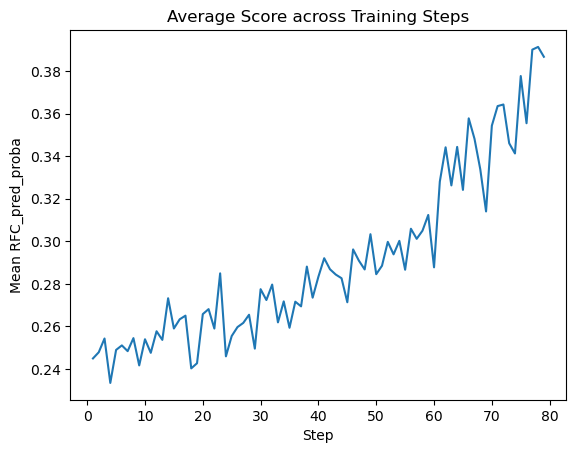

In [22]:
# To visualize the learning process, we will observe the average score across training steps.
df = pd.read_csv(scores_path, index_col=0)
grouped_data = df.groupby(['step'])['RFC_pred_proba'].mean()
plt.plot(grouped_data.index, grouped_data.values)
plt.xlabel('Step')
plt.ylabel('Mean RFC_pred_proba')
plt.title('Average Score across Training Steps')
plt.show()

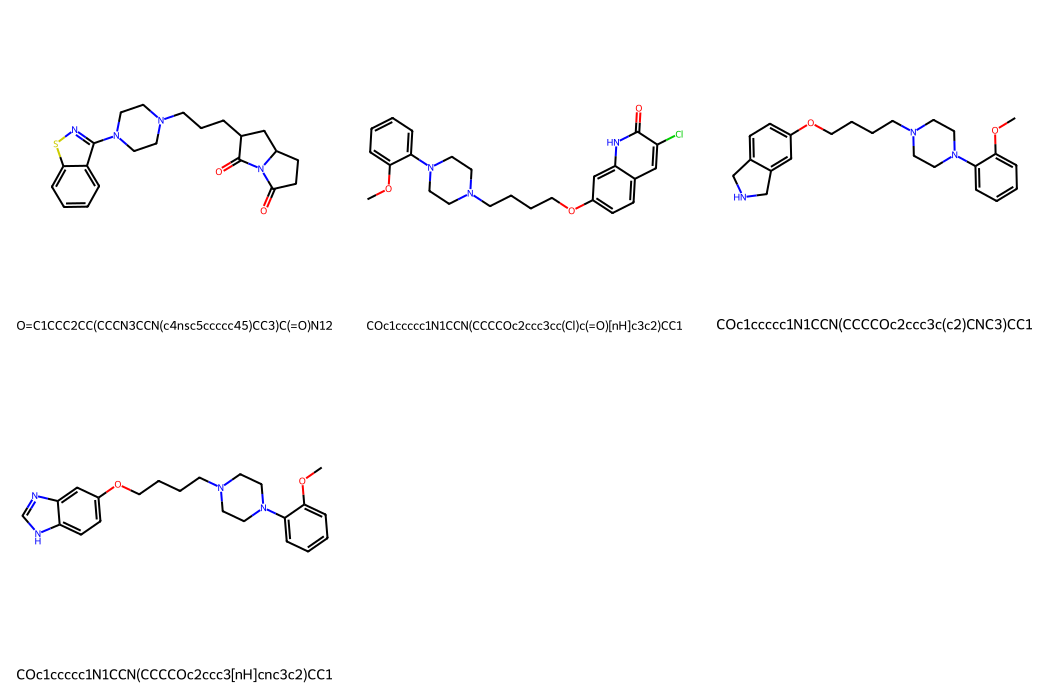

In [23]:
# Drawing the active molecules using rdkit
active_molecules['molecules'] = active_molecules['smiles'].apply(Chem.MolFromSmiles)
molecules = active_molecules['molecules'].tolist()[:9]
molecules_image = Draw.MolsToGridImage(
    molecules,
    molsPerRow=3,
    subImgSize=(350, 350),
    legends=active_molecules['smiles'].tolist()[:9]
)
molecules_image

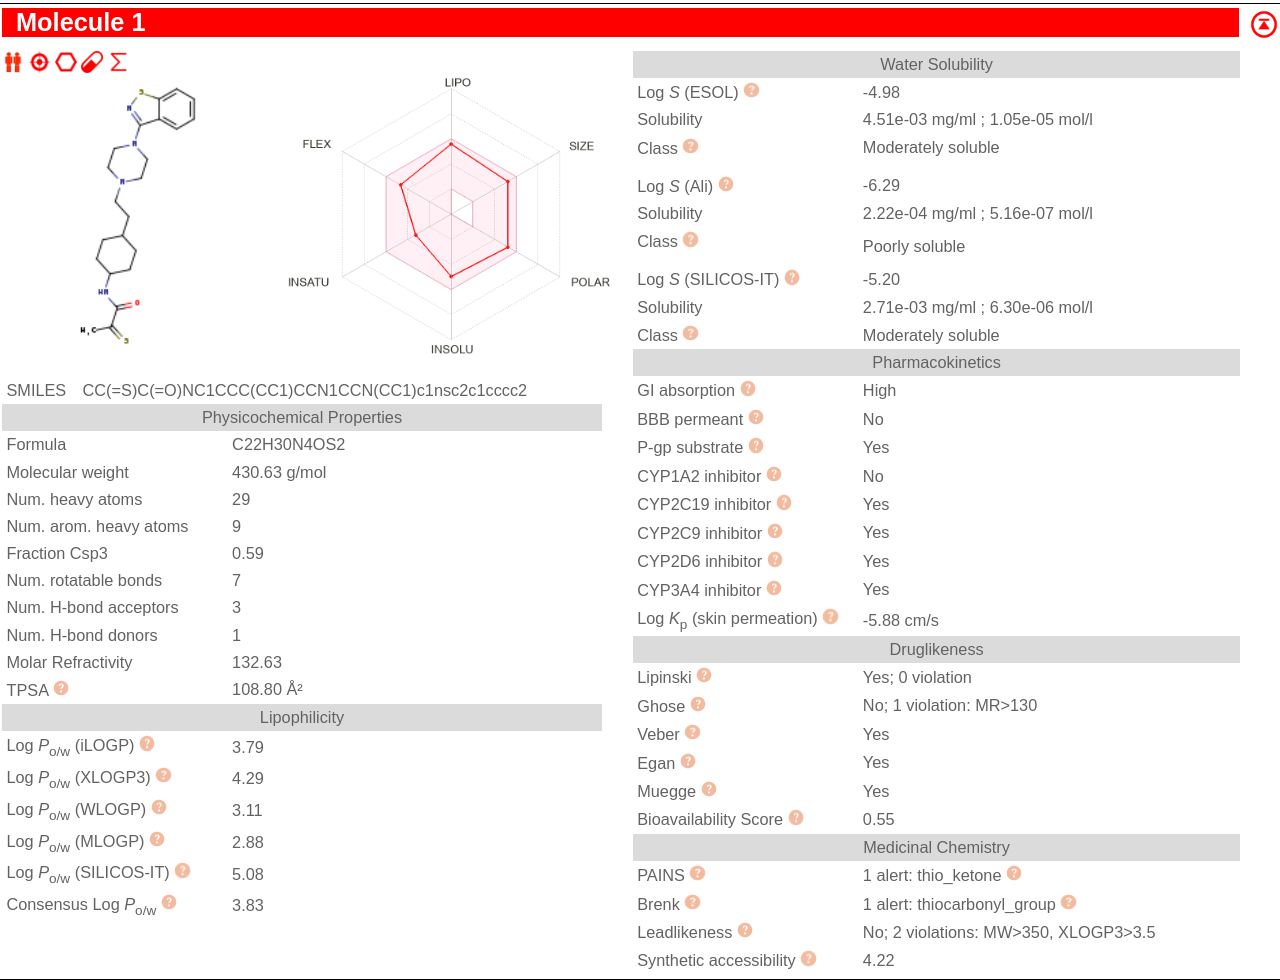

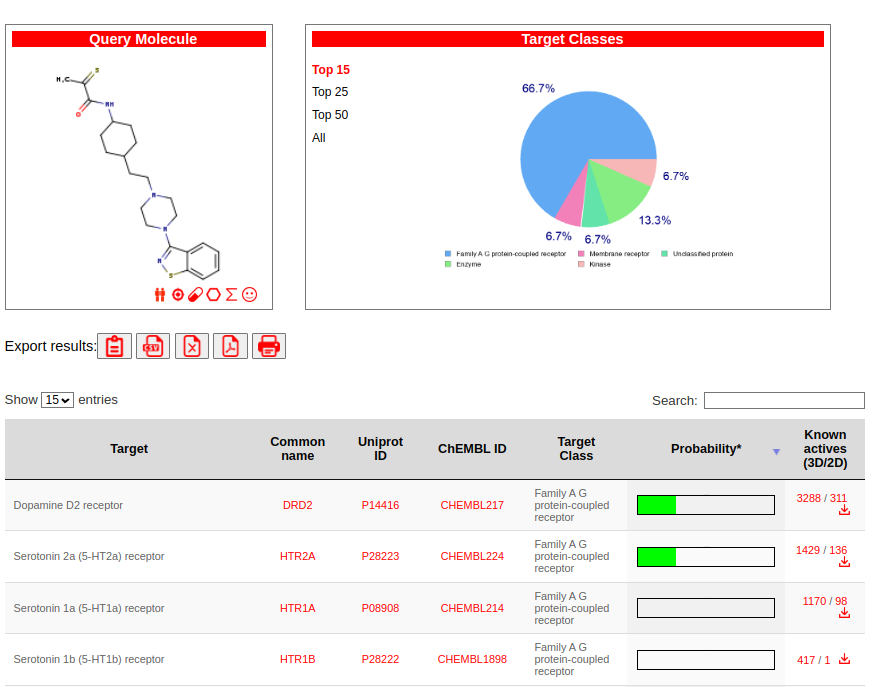

In [9]:
scores_path = "results/SMINA_reinvent_2025_01_09_124546/2025_01_09_reinvent_SMINA/scores_512.csv"
active_molecules = get_active_molecules(scores_path, filtering_threshold=12.5, metric="smina_docking_score")
active_molecules = active_molecules.sort_values("smina_docking_score")

# Finally, let's save the identified active molecules
save_active_molecules(active_molecules, filename="SMINA_512.txt")
active_molecules

max predicted probability: 0.0
median predicted probability: -9.8


,model,task,step,batch_idx,absolute_time,smiles,valid,valid_score,unique,occurrences,smina_docking_score,smina_NetCharge,smina_PositiveCharge,smina_NegativeCharge,smina_best_variant,raw_smina_docking_score,single,filter,score_time
11,reinvent,docking_score,4,2,676.818870,N#Cc1ccc(N2NC(=O)C3(CN(c4ccc(-c5ccc(F)cc5)cc4)...,True,1,True,0,-13.4,0.0,1.0,-1.0,4_2-0,0.000001,0.000001,1.0,249.107522
9,reinvent,docking_score,10,2,3068.650365,O=S(=O)(c1cccc(C(F)(F)F)c1)N1CC(CN2CCC(O)(c3cc...,True,1,True,0,-13.3,1.0,1.0,0.0,10_2-1,0.000001,0.000001,1.0,278.168114
10,reinvent,docking_score,51,1,12891.739227,O=C1C(c2c[nH]c3ccccc23)=[N+](c2ccccc2Cl)N1CCCC...,True,1,True,0,-13.3,1.0,1.0,0.0,51_1-0,0.000001,0.000001,1.0,338.303561
8,reinvent,docking_score,62,3,15733.845674,Cc1c(Oc2cccc3[nH]ncc23)cccc1C(=O)NCC(=O)Nc1c(C...,True,1,True,0,-13.0,0.0,0.0,0.0,62_3-3,0.000001,0.000001,1.0,348.685983
7,reinvent,docking_score,118,0,29830.689606,Cc1ccc(C#Cc2ccc(C(=O)N3CCCC3)cc2C)c(NC(=O)c2cc...,True,1,True,0,-12.9,1.0,1.0,0.0,118_0-4,0.000001,0.000001,1.0,312.882324
6,reinvent,docking_score,97,2,24299.084372,O=C(Nc1ccc(Nc2cccc3c2CNC3=O)nc1)c1ccccc1Cl,True,1,True,0,-12.7,0.0,0.0,0.0,97_2-2,0.000001,0.000001,1.0,173.976013
3,reinvent,docking_score,88,2,22706.332225,NC(=O)c1ccc2[nH]c(-c3ccc(C[S+]([O-])Cc4ccc([N+...,True,1,True,0,-12.6,1.0,1.0,0.0,88_2-5,0.000001,0.000001,1.0,119.400155
4,reinvent,docking_score,92,2,23312.432942,Cc1nccc2c1-c1nc(C(=O)N3CCC4(CCOc5ccccc54)C3)cc...,True,1,True,0,-12.6,2.0,2.0,0.0,92_2-7,0.000001,0.000001,1.0,187.283513
5,reinvent,docking_score,113,3,29023.768365,Cc1cc2nc(NS(=O)(=O)c3ccc4cc(N)oc4c3)nc(C(=O)NC...,True,1,True,0,-12.6,0.0,0.0,0.0,113_3-3,0.000001,0.000001,1.0,266.357455
0,reinvent,docking_score,76,1,19693.981012,CCN1CC(NC(=O)Nc2cc3ncc(-c4ccc(F)nc4)cc3cn2)C(c...,True,1,True,0,-12.5,0.0,0.0,0.0,76_1-5,0.000001,0.000001,1.0,389.056975


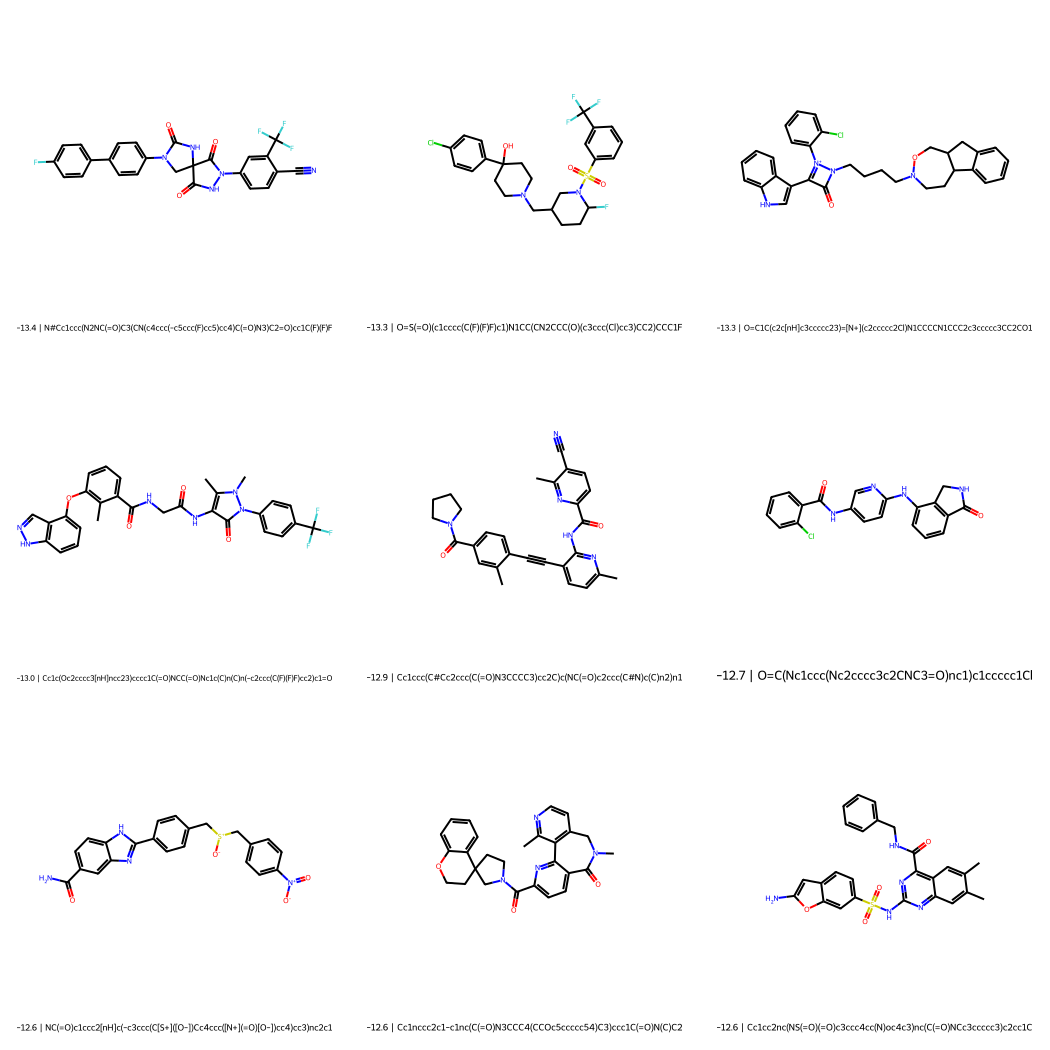

In [10]:
# Drawing the active molecules using rdkit
active_molecules['molecules'] = active_molecules['smiles'].apply(Chem.MolFromSmiles)
molecules = active_molecules['molecules'].tolist()[:9]
legends = zip(active_molecules['smina_docking_score'].tolist()[:9], active_molecules['smiles'].tolist()[:9])
molecules_image = Draw.MolsToGridImage(
    molecules,
    molsPerRow=3,
    subImgSize=(350, 350),
    legends= [f"{i} | {j}" for i , j in legends]
)
molecules_image

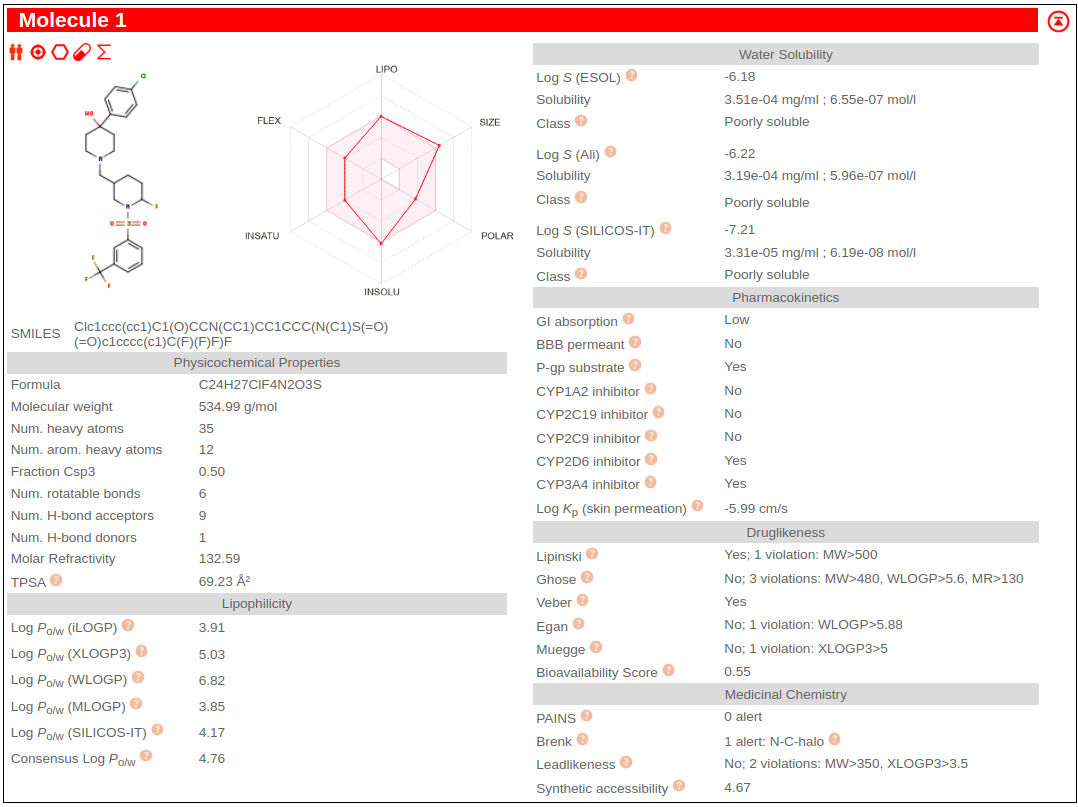

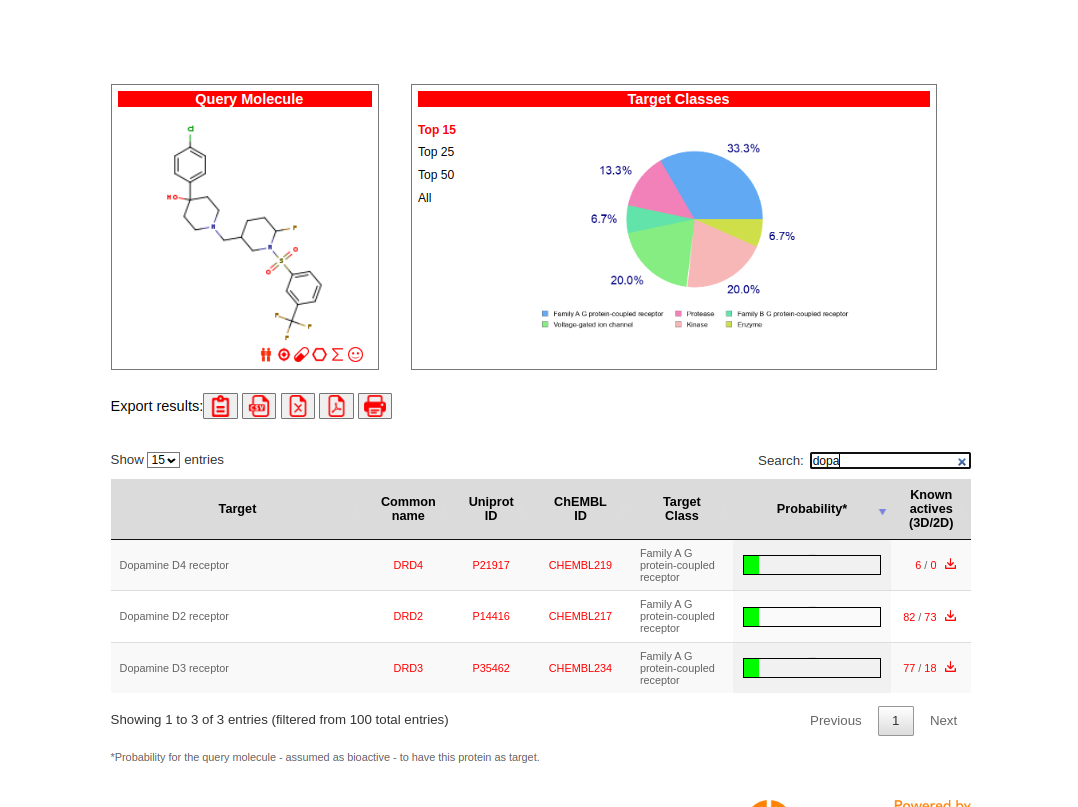

### Load and draw molecules

_Explain what you will do and why here in the Markdown cell. This includes everything that has to do with the talktorial's storytelling._

In [5]:
# Add comments in the code cell if you want to comment on coding decisions

## Discussion

Wrap up the talktorial's content here and discuss pros/cons and open questions/challenges.

## Quiz

Ask three questions that the user should be able to answer after doing this talktorial. Choose important take-aways from this talktorial for your questions.

1. Question
2. Question
3. Question

<div class="alert alert-block alert-info">

<b>Useful checks at the end</b>: 
    
<ul>
<li>Clear output and rerun your complete notebook. Does it finish without errors?</li>
<li>Check if your talktorial's runtime is as excepted. If not, try to find out which step(s) take unexpectedly long.</li>
<li>Flag code cells with <code># TODO: CI</code> that have deterministic output and should be tested within our Continuous Integration (CI) framework.</li>
</ul>

</div>